In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import pandas as pd
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, PegasusConfig
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer


In [3]:
#globals
MAX_LENGTH = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
#dataset and tokenizer building
#load our 10k data into a dataframe
limit = 10
papers = []
for root, dirs, files in os.walk("./data/mini_10k"):
    for f in files:
        fn = root+"/"+f
        with open(fn) as jsonfile:
            d = json.load(jsonfile)
        papers.append(d)
        
        if len(papers) >= limit:
            break
    if len(papers) >= limit:
        break
df = pd.DataFrame(papers)

In [5]:
#load our rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

In [6]:
#load our pretrained model
model_name = 'google/pegasus-large'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
config = PegasusConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)  
pt_model = PegasusForConditionalGeneration.from_pretrained(model_name, config=config).to(device)

In [7]:
#example batch (size 1)
batch = tokenizer(df.fulltext[3], truncation=True, padding='longest', return_tensors="pt").to(device)
print(batch.keys())

dict_keys(['input_ids', 'attention_mask'])


In [8]:
#example pretrained generation with keys
out = pt_model.generate(return_dict_in_generate=True, **batch)
print(out.keys())
print(len(out["encoder_hidden_states"]))

odict_keys(['sequences', 'encoder_attentions', 'encoder_hidden_states', 'decoder_attentions', 'decoder_hidden_states'])
17


In [9]:
class AttentionAttention(nn.Module):
    def __init__(self,  
                 vocab_size=32000, 
                 input_size=1024, 
                 target_size=256):
        super(AttentionAttention, self).__init__()
        
        
        #attn head1
        self.ah1_1 = nn.Linear(input_size, target_size)
        self.ah1_2 = nn.Linear(target_size, target_size//2)
        self.ah1_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head2
        self.ah2_1 = nn.Linear(input_size, target_size)
        self.ah2_2 = nn.Linear(target_size, target_size//2)
        self.ah2_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head3
        self.ah3_1 = nn.Linear(input_size, target_size)
        self.ah3_2 = nn.Linear(target_size, target_size//2)
        self.ah3_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head4
        self.ah4_1 = nn.Linear(input_size, target_size)
        self.ah4_2 = nn.Linear(target_size, target_size//2)
        self.ah4_3 = nn.Linear(target_size//2, target_size//4)
 
        #compression layer
        self.fc_comp = nn.Linear(target_size, target_size)
        
        #output head
        self.fc_out = nn.Linear(target_size, vocab_size)
        
        #dropout layer
        self.do = nn.Dropout(p=0.2)
            
        #mapping variable
        self.node2attn = {}
        
    def forward(self, out, print_attn=False):
        
        
        assert(len(out["encoder_attentions"])==16)
        
        #initialize a random tensor as our 'shallow' attn
        shallow_attn1 = torch.rand((1024,1024), requires_grad=True).to(device)
        shallow_attn2 = torch.rand((1024,1024), requires_grad=True).to(device)
        shallow_attn3 = torch.rand((1024,1024), requires_grad=True).to(device)
        shallow_attn4 = torch.rand((1024,1024), requires_grad=True).to(device)
        
        #pull only from these attn layers
        self.node2attn = {
            0:shallow_attn1,
            1:shallow_attn2,
            2:shallow_attn3,
            4:shallow_attn4,
        }
        
        for i,attn in enumerate(out["encoder_attentions"]):
            if i not in self.node2attn:
                continue
            
            for j,block in enumerate(attn[0]):
                attn = torch.tensor(block).to(device)
                
                #get our shallow attn tensor (right now just noise)
                shallow_attn = self.node2attn[i]
                
                #experiment 0
                #add our attention to the noise
                shallow_attn = shallow_attn.add(attn)
                
                # experiment 1, ab,cd->bc
                #shallow_attn = torch.einsum("ab,cd->bc", shallow_attn, attn)
                
                #experiment 2, ab,cd->ad
                shallow_attn = torch.einsum("ab,cd->ad", shallow_attn, attn)
                
                #optional debug, print attn
                if print_attn:
                    plt.matshow(shallow_attn.cpu().detach().numpy())
                    plt.show()
                
                
                
                #just take the first shallow attn
                #break out from inner loop
                break
                    
        
        
        #values,indices = torch.sort(global_attn)
        
        
        #learn from shallow_attn1
        x1 = F.relu(self.ah1_1(shallow_attn1))
        x1 = F.relu(self.ah1_2(x1))
        x1 = F.relu(self.ah1_3(x1))
        
        #learn from shallow_attn2
        x2 = F.relu(self.ah2_1(shallow_attn2))
        x2 = F.relu(self.ah2_2(x2))
        x2 = F.relu(self.ah2_3(x2))
        
        #learn from shallow_attn3
        x3 = F.relu(self.ah3_1(shallow_attn3))
        x3 = F.relu(self.ah3_2(x3))
        x3 = F.relu(self.ah3_3(x3))
        
        #learn from shallow_attn4
        x4 = F.relu(self.ah4_1(shallow_attn4))
        x4 = F.relu(self.ah4_2(x4))
        x4 = F.relu(self.ah4_3(x4))
                
        #concatenate all heads
        #print(x1.shape, x2.shape, x3.shape)
        x_concat = torch.cat((x1,x2,x3,x4), 1)
        
        print(x_concat.shape)

        x = F.relu(self.fc_comp(x_concat))
        
        #add dropout
        x = self.do(x)
        
        #run through our final output layer
        x = F.relu(self.fc_out(x))
        
        print(x.shape)

        return x

In [10]:
aa = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)

<ipython-input-9-a45eb6f7e8d3>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn = torch.tensor(block).to(device)


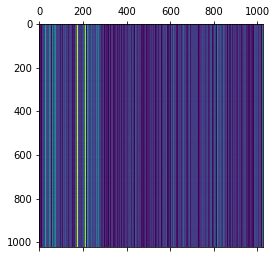

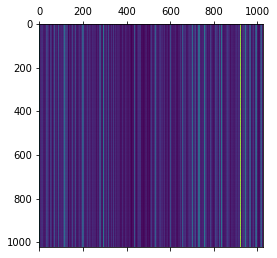

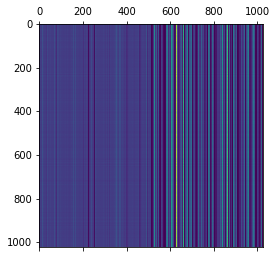

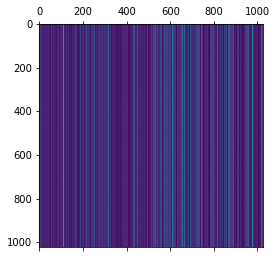

torch.Size([1024, 256])
torch.Size([1024, 96103])


torch.Size([1024, 96103])

In [11]:
o3 = aa.forward(out, print_attn=True)
o3.shape

In [12]:
def summary2tensor(summary, batch_size=1, vocab_size=32000):
    z = torch.zeros(batch_size,vocab_size).to(device)
    for i,wid in enumerate(summary):   
        z[i][wid] = 1.0 
    return z


def pred2tensor(pred):
    ids = []
    for r in pred:
        idx = torch.argmax(r)
        ids.append(idx)
    return torch.tensor(ids)

In [13]:
#load the model from disk
#aa = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)
#aa.load_state_dict("data/aa_model.state")
#aa.eval()

In [14]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()

for param in aa.parameters():
    param.requires_grad = True

lr = 5.0 # learning rate
optimizer = torch.optim.SGD(aa.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
ntokens = tokenizer.vocab_size

for i in range(len(papers)):
    
    batch = tokenizer(df.fulltext[i], truncation=True, padding='longest', return_tensors="pt").to(device)
    
    out = pt_model.generate(return_dict_in_generate=True, **batch)
    
    try:
        pred = aa.forward(out)
    except Exception as e:
        print(e)
        continue
    
    y = tokenizer(df.summary[i], truncation=True, padding='longest', return_tensors="pt").to(device)
    y = y["input_ids"]
    y = summary2tensor(y, batch_size=1024, vocab_size=tokenizer.vocab_size)
    #print(pred.shape, y.shape)
    #print(pred)
    loss = loss_fn(pred, y)
    print("{} {}".format(i, loss.item()))
    loss.backward()
    optimizer.step()
    break
    
    

<ipython-input-9-a45eb6f7e8d3>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn = torch.tensor(block).to(device)


torch.Size([1024, 256])
torch.Size([1024, 96103])
0 0.0009161891066469252


In [ ]:
#tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)
#print(" ".join(tgt_text))

In [1]:
#save the model to disk
torch.save(aa.state_dict(), "data/aa_model.state")

NameError: name 'torch' is not defined

In [18]:
def decode_output(pred):
    ids = []
    for x in pred:
        pred_id = torch.argmax(x)
        ids.append(pred_id)
    return ids

In [19]:
#example generate summary from fulltext
summary, fulltext = df.summary[3], df.fulltext[3]
batch = tokenizer(fulltext, truncation=True, padding='longest', return_tensors="pt").to(device)
out = pt_model.generate(return_dict_in_generate=True, **batch)
pred = aa.forward(out)
ids = decode_output(pred)
tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)
tgt_text = " ".join(tgt_text)
print(tgt_txt)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


42 Volcano TAC cesium 42 studied cesium studied Out TAC bluetooth Malwarebytes Malwarebytes studied 42 Malwarebytes 42 studied Malwarebytes Stenographer 42 studied moisturiser moisturiser 42 hier TAC Acqui 42 cesium 42 studied Malwarebytes 42 studied 42 Acqui Malwarebytes Malwarebytes Malwarebytes Malwarebytes moisturiser TAC robin Malwarebytes Malwarebytes Volcano yards yards studied 42 cesium studied 42 42 studied TAC 42 studied 42 TAC Malwarebytes TAC Malwarebytes robin moisturiser studied telugu 42 42 Malwarebytes Sheds studied studied 42 42 42 studied studied yards 42 studied studied studied studied 42 moisturiser 42 yards cesium moisturiser Volcano moisturiser 42 rot studied 42 studied Malwarebytes Volcano studied 42 studied Malwarebytes implicate cesium Malwarebytes bookcase 42 studied 42 studied studied robin TAC TAC Sheds 42 wired 42 bookcase studied studied TAC telugu Acqui Sheds Malwarebytes studied TAC studied telugu TAC shuffle telugu 42 cesium 42 TAC 42 TAC studied Volcan

In [23]:
tgt_text = " ".join(tgt_text)

score = scorer.score(tgt_text, summary)
score

{'rouge1': Score(precision=0.03676470588235294, recall=0.0008163265306122449, fmeasure=0.0015971889474524835),
 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0)}